# Maximum Likelihood Estimation of a GARCH model 

### This code estimates the parameters ($\mu^{\ast}$, $\delta^{\ast}$ and $\phi^{\ast}$) of a GARCH(1,1) model by maximizing the standardized (by $T$) log likelihood:

\begin{equation*}
Q_T(\theta) = \frac{1}{T}\log(L(\{x\},\mu^{\ast}, \delta^{\ast}, \phi^{\ast}))= - \frac{1}{2}\log (2\pi)-\frac{\sum _{t=1}^{T}}{2T}\log 
h_{t}-\frac{\sum _{t=1}^{T}}{2T}\left( \frac{\varepsilon _{t}^{2}}{h_{t}}\right),
\end{equation*}
with
$$h_t = \mu ^{\ast }+\delta ^{\ast }h_{t-1}+\phi^{\ast }\varepsilon_{t-1}^{2}.$$

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from platform import python_version

In [2]:
# The recommended python version is 3.8 or 3.9
print(python_version())
# Adjust the plot size on your computer
plt.rcParams['figure.figsize'] = [7, 7]
# Check current directory
os.getcwd()

3.9.13


'/Users/federico/Dropbox/nonlineareconometrics2024/FEDERICO/Python_codes'

## Let us begin by uploading the data

In [3]:
data = pd.read_excel('SP500daily_level.xlsx')
data 

,date,sp500level
0,19800102,105.76
1,19800103,105.22
2,19800104,106.52
3,19800107,106.81
4,19800108,108.95
...,...,...
6810,20061222,1410.76
6811,20061226,1416.90
6812,20061227,1426.84
6813,20061228,1424.73


## Let us now extract prices and compute continuously-compounded returns

In [4]:
# We go from prices to log (or continuously-compounded) returns
prices = np.array(data.iloc[:, 1])
ret = np.log(prices[1:] / prices[:-1])
T = len(ret)

## Always plot the data (if you can): why do we need a GARCH model? Let's see ...

Text(0.5, 0, 'time')

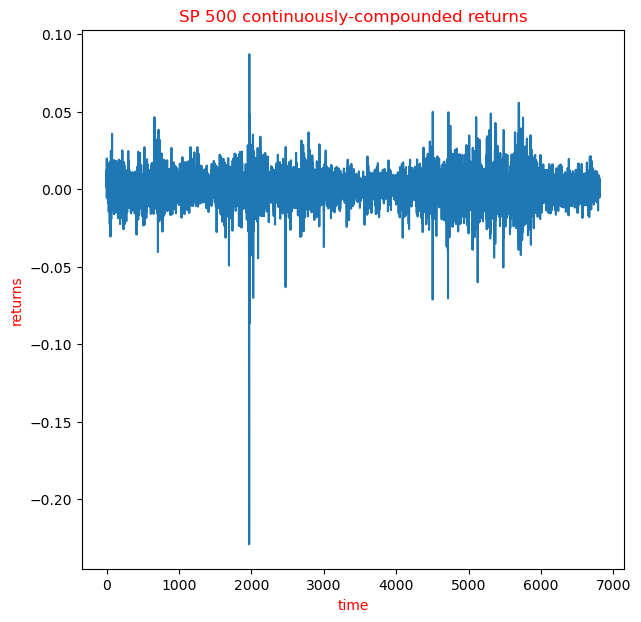

In [5]:
plt.plot(ret)
plt.title('SP 500 continuously-compounded returns', color = 'red')
plt.ylabel('returns', color = 'red')
plt.xlabel('time', color = 'red')

## (1) We define the standardized log-likelihood function

In [6]:
def garchloglik(theta,ret):
    
    [mu, delta, phi] = theta
    
    h1 = np.var(ret, ddof=1)          # Recall h needs to be initiated (we loop over h)
                                      # Initial value of h: we use the unconditional empirical variance from the data

    h    =   h1
    sum1 = - 1 / 2 * np.log(h1) /T
    sum2 = - ret[0]**2 / (2 * h1 * T)

    for t in range(1, T): 
        h = mu + delta * h + phi * ret[t-1]**2
        sum1 = sum1 - 1 / 2 * np.log(h)/T
        sum2 = sum2 - ret[t]**2 / (2 * h * T)

    # Note 1: I am excluding the first term in the log likelihood since it does not affect the maximum
    # Note 2: Below I will change the sign of the likelihood. We are maximizing, not minimizing.
    
    y = - (sum1 + sum2)
    return y

## (2) Estimation

The ML estimates are:

\begin{eqnarray*}
\widehat{\theta }_{MLE}&=&\underset{\theta}{\arg \max }\left[Q_{T}(\theta )\right] \\
&=& \underset{\theta = (\mu^{\ast}, \delta^{\ast}, \phi^{\ast})}{\arg \max }{\frac{1}{T}\log(L(\{x\},\mu^{\ast}, \delta^{\ast}, \phi^{\ast}))}\\
&=&\underset{\theta = (\mu^{\ast}, \delta^{\ast}, \phi^{\ast}) }{\arg \max }\left(\frac{1}{2}\log (2\pi)-\frac{\sum _{t=1}^{T}}{2T}\log 
h_{t}-\frac{\sum _{t=1}^{T}}{2T}\left( \frac{\varepsilon _{t}^{2}}{h_{t}}\right)\right)
\end{eqnarray*}

In [7]:
theta_guess = [0.2, 0.5, 0.5]  

estimates = scipy.optimize.fmin(func=garchloglik, 
                                x0=theta_guess, 
                                args=(ret,), 
                                xtol=1e-10, 
                                ftol=1e-10, 
                                disp=0)  

table = pd.DataFrame({'Estimates':estimates}, index = ['mu', 'delta','phi'])
table

/var/folders/xf/zsdpj0kj2g9c1ybcmmdbvd8m0000gn/T/ipykernel_14477/1190580667.py:14: RuntimeWarning: invalid value encountered in log
  sum1 = sum1 - 1 / 2 * np.log(h)/T


,Estimates
mu,0.000001
delta,0.923810
phi,0.068592


## (3) Asymptotic Inference

We know that the ML estimator is asymptotically normal:
\begin{equation*}
\sqrt{T}\left( \widehat{\theta }_{MLE} -\theta _{0}\right) \overset{d}{\rightarrow} N(0,\Omega_{0}^{-1})
\end{equation*}
with $$\Omega_0 = \mathbb{E}\left( \frac{\partial \log p(r_{t}|r_{t-1},...,\theta _{0})}{%
\partial \theta }\frac{\partial \log p(r_{t}|r_{t-1},...,\theta _{0})}{%
\partial \theta ^{^{\top }}}\right).$$

Thus,

\begin{equation*}
\widehat{\mathbb{V}}(\widehat{\theta}_{MLE})= \frac{1}{T}(\widehat{\Omega}_0)^{-1} = \frac{1}{T}\left(\frac{1}{T}\sum_{t=1}^{T}\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{%
\partial \theta }\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{%
\partial \theta ^{^{\top }}}\right)^{-1}.
\end{equation*}

But, in this model,
\begin{equation*}
\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{\partial \theta }=\begin{pmatrix}\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{\partial \mu^{\ast} } \\\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{\partial \delta^{\ast} } \\ \frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{\partial \phi^{\ast} } \end{pmatrix}=\underbrace{\left(-\frac{1}{2}\frac{1}{\widehat{h}_t}+\frac{1}{2}\frac{\varepsilon^2_t}{\widehat{h}_t^2} \right)}_{\frac{\partial \log p(r_{t}|r_{t-1},...,\widehat{\theta} _{MLE})}{\partial \widehat{h}_t}} \begin{pmatrix} \frac{\partial \widehat{h}_t}{\partial \mu^{\ast}} \\ \frac{\partial \widehat{h}_t}{\partial \delta^{\ast}}  \\ \frac{\partial \widehat{h}_t}{\partial \phi^{\ast}} \end{pmatrix},
\end{equation*}
where
\begin{equation*}
\begin{pmatrix} \frac{\partial \widehat{h}_t}{\partial \mu^{\ast}} \\ \frac{\partial \widehat{h}_t}{\partial \delta^{\ast}}  \\ \frac{\partial \widehat{h}_t}{\partial \phi^{\ast}} \end{pmatrix}=\begin{pmatrix} 1+ \widehat{\delta}^{\ast}\frac{\partial \widehat{h}_{t-1}}{\partial \mu^{\ast}} \\ \widehat{h}_{t-1}+\widehat{\delta}^{\ast}\frac{\partial \widehat{h}_{t-1}}{\partial \delta^{\ast}}  \\ \varepsilon^2_{t-1}+\widehat{\delta}^{\ast}\frac{\partial \widehat{h}_{t-1}}{\partial \phi^{\ast}} \end{pmatrix},
\end{equation*}
since $h_t=\mu ^{\ast }+\delta ^{\ast }h_{t-1}+\phi^{\ast }\varepsilon_{t-1}^{2}.$


In [8]:
h = np.var(ret, ddof=1) * np.ones(T)

dh_mu = np.zeros(T)
dh_delta = np.zeros(T)
dh_phi = np.zeros(T)

sum3 = np.zeros([3, 3])

for t in range(1, T):
    h[t] = estimates[0] + estimates[1] * h[t - 1] + estimates[2] * ret[t - 1]**2
    
    dlogp_h = - (1 / 2) * 1 / h[t] + (1 / 2) * ret[t]**2 / (h[t] ** 2)
    
    dh_mu[t] = 1 + estimates[1] * dh_mu[t - 1]
    dh_delta[t] = h[t - 1] + estimates[1] * dh_delta[t - 1]
    dh_phi[t] = ret[t - 1]**2 + estimates[1] * dh_phi[t - 1]

    dh = np.array([dh_mu[t], dh_delta[t], dh_phi[t]]).T

    grad = np.multiply(dlogp_h, dh)
    sum3 = sum3 + np.outer(grad, grad)/T

VarCov = (1 / T) * np.linalg.inv(sum3)
t_stats = estimates / np.sqrt(np.diag(VarCov))

table = pd.DataFrame({'Estimates': estimates, 't statistics': t_stats}, index = ['mu', 'delta','phi'])
table

,Estimates,t statistics
mu,0.000001,7.918245
delta,0.923810,324.985961
phi,0.068592,46.548826


## Value-at-Risk 

In [9]:
h_next = estimates[0] + estimates[1] * h[-1] + estimates[2] * ret[-1]**2
VaR = 1000000 * 2.33 * np.sqrt(h_next)

print(f'The 1% Value-at-Risk for an investor holding a "market-like" portfolio is {VaR:.2f}')

The 1% Value-at-Risk for an investor holding a "market-like" portfolio is 13072.41
